In [2]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
import torch.backends.cudnn as cudnn
import matplotlib .pyplot as plt
from itertools import permutations

torch.manual_seed(28)
cudnn.deterministic = True

def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
print(mrs_name)
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]

['rotate', 'enh_bri', 'enh_sha', 'enh_con', 'gaussian', 'shear', 'translate']


In [60]:
class CustomDataset(Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.labels[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, label


In [61]:
# 定义变分自编码器（VAE）模型
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size * 2 )  # 输出均值和方差
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # 输出值范围在 [0, 1] 之间（因为MNIST像素值在 [0, 1]）
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # 编码
        latent_params = self.encoder(x)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        z = self.reparameterize(mu, logvar)

        # 解码
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


# 设定超参数和数据加载器
batch_size = 128
input_size = 28 * 28  # MNIST图像大小为28x28
hidden_size = 400
latent_size = 200
lr = 1e-3
epochs = 50

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_set = datasets.MNIST('data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# 创建VAE模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_size, hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [62]:
# 训练VAE模型
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_size).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        BCE = criterion(recon_batch, data)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + KLD
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader.dataset)}")

# 评估模型
model.eval()
test_loss = 0.0
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.view(-1, input_size).to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += criterion(recon_batch, data).item()

test_loss /= len(test_loader.dataset)
print(f"Test set loss: {test_loss:.4f}")

Epoch 1/50, Loss: 188.79633644205728
Epoch 2/50, Loss: 145.50674946289064
Epoch 3/50, Loss: 128.45397190755207
Epoch 4/50, Loss: 121.08474156901042
Epoch 5/50, Loss: 116.04471796875
Epoch 6/50, Loss: 112.71958779296875
Epoch 7/50, Loss: 110.76617317708333
Epoch 8/50, Loss: 109.35060994466146
Epoch 9/50, Loss: 108.05620704752604
Epoch 10/50, Loss: 107.01044973958334
Epoch 11/50, Loss: 105.99543024088541
Epoch 12/50, Loss: 105.25902236328125
Epoch 13/50, Loss: 104.70461793619792
Epoch 14/50, Loss: 104.26668326822917
Epoch 15/50, Loss: 103.79088212890625
Epoch 16/50, Loss: 103.45554552408854
Epoch 17/50, Loss: 103.14986329752604
Epoch 18/50, Loss: 102.87762250976563
Epoch 19/50, Loss: 102.57545515950521
Epoch 20/50, Loss: 102.38284611002604
Epoch 21/50, Loss: 102.06277849934895
Epoch 22/50, Loss: 101.8721053548177
Epoch 23/50, Loss: 101.634744921875
Epoch 24/50, Loss: 101.27258038736979
Epoch 25/50, Loss: 101.13905377604166
Epoch 26/50, Loss: 100.95897060546875
Epoch 27/50, Loss: 100.7378

In [66]:
torch.save(model.state_dict(), 'results/SelfOracle/MNIST_VAE.pth')

In [94]:
import numpy as np
from scipy.stats import gamma

criterion = nn.BCELoss(reduction='mean')

#将训练集的误差存起来
error_testing = np.zeros(len(test_set))
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

model.to(device)
model.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.view(-1, input_size).to(device)
        recon_batch, _, _ = model(data)
        error_testing[i] = criterion(recon_batch, data).item()

#拟合一个分布
shape, loc, scale = gamma.fit(error_testing, floc=0)
false_alarm = 0.0001

#求出上百分之一分位数
threshold = gamma.ppf(1-false_alarm, shape, loc, scale)

print(threshold)
print(np.where(error_testing>threshold)[0].size)



0.2702949347901662
3


In [95]:
with open('results/SelfOracle/threshold.txt', 'w') as f:
    f.write(f'False_alarm: {false_alarm}\n')
    f.write(f'Tthreshold: {threshold}\n')

In [104]:
criterion = nn.BCELoss(reduction='mean')
test_set = datasets.MNIST('data', train=False, download=True)
result_selfOracle = {}
batch_size = 1
model.eval()
model.to(device)
for i in range(len(mrs)):
    for cmr in permutations(range(len(mrs)), i+1):
        result_selfOracle[cmr] = []
        followup_test_set = CustomDataset(test_set, cmr, transform=transform)
        followup_test_loader = DataLoader(followup_test_set, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(followup_test_loader):
                data = data.view(-1, input_size).to(device)
                recon, _, _ = model(data)
                error = criterion(recon, data)
                result_selfOracle[cmr].append(error.cpu().item())
        print(cmr)

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(1, 0)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(2, 0)
(2, 1)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 0)
(3, 1)
(3, 2)
(3, 4)
(3, 5)
(3, 6)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 5)
(4, 6)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 6)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 2, 1)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 3, 1)
(0, 3, 2)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 4, 1)
(0, 4, 2)
(0, 4, 3)
(0, 4, 5)
(0, 4, 6)
(0, 5, 1)
(0, 5, 2)
(0, 5, 3)
(0, 5, 4)
(0, 5, 6)
(0, 6, 1)
(0, 6, 2)
(0, 6, 3)
(0, 6, 4)
(0, 6, 5)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 2, 0)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 3, 0)
(1, 3, 2)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 4, 0)
(1, 4, 2)
(1, 4, 3)
(1, 4, 5)
(1, 4, 6)
(1, 5, 0)
(1, 5, 2)
(1, 5, 3)
(1, 5, 4)
(1, 5, 6)
(1, 6, 0)
(1, 6, 2)
(1, 6, 3)
(1, 6, 4)
(1, 6, 5)
(2, 0, 1)
(2, 0, 3)
(2, 0, 4)
(2, 0, 5)
(2, 0, 6)
(2, 1, 0)
(2, 1, 3)
(

In [109]:
print(type(result_selfOracle))
print(len(result_selfOracle))

np.save('results/SelfOracle/MNIST_validity.npy', result_selfOracle)

<class 'dict'>
13699


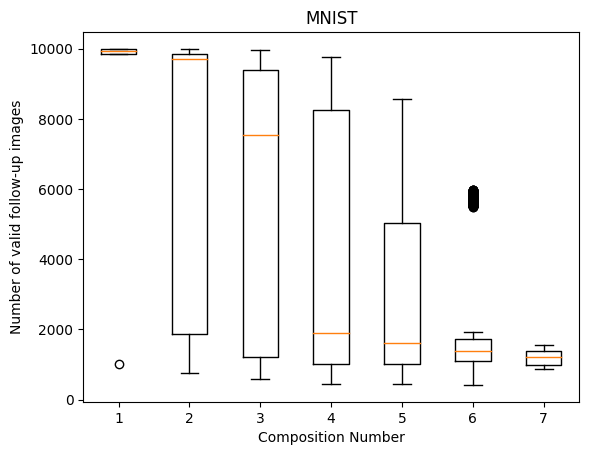

In [8]:
result_selfOracle = np.load('results/SelfOracle/MNIST_validity.npy', allow_pickle=True).item()

th = 0.2702949347901662
data = [[] for _ in range(len(mrs))]
for cmr in result_selfOracle.keys():
    data[len(cmr)-1].append(len(np.where(np.array(result_selfOracle[cmr])<=th)[0]))

# 创建箱线图
plt.boxplot(data, patch_artist=False)

# 设置图表标题和轴标签
plt.title('MNIST')
plt.xlabel('Composition Number')
plt.ylabel('Number of valid follow-up images')

plt.savefig('results/SelfOracle/MNIST_validity.pdf', dpi=600)

# 显示图表
plt.show()
